# 2. Regression <br/> <sub>or _exploration of bias & variance_</sub>
<br/>

We play further with model complexity, and check its influence on both the in-training and off-training (test) errors.

This time, for a change, we focus on a regression problem. For simplicity, we'll use synthetic data.
First, the usual generic imports.

In [1]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

Define the dataset we'll try to estimate. We'll use the [Friedman2](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman2.html) synthetic dataset, as implemented in scikit-learn:

$$ F_2 = \sqrt{ X_1^2 + X_2 X_3 - \frac{1}{(X_2 X_4)^2}} +k \sigma(0,1)$$

where $X_i$ are random uniform variables in different intervals, and $\sigma$ is Gaussian noise.

An alternative is the Friedman 1 signal:

$ F_1 = sin(\pi X_1 X_2) + 20*(X_3-1/2)^2 + 10X_3 + 5X_4 + k \sigma(0,1) $


In [8]:
# Use a synthetic dataset
from sklearn import datasets
from sklearn.utils import shuffle, check_random_state

def myDataset( num_points ):
    rs = check_random_state( 42 )
    #return datasets.make_friedman1(num_points, 10, noise=1.0, random_state=rs)
    return datasets.make_friedman2(num_points, noise=4.0, random_state=rs)

X0, y0 = myDataset(100)

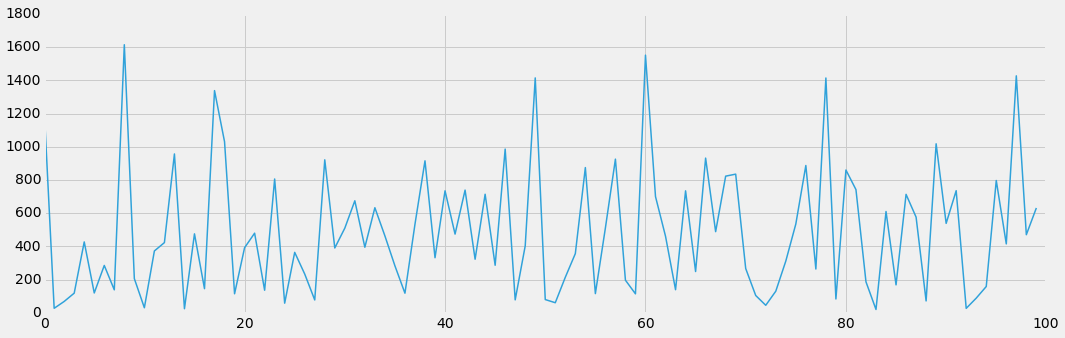

In [9]:
# Plot the result
plt.figure( 1, (16,5), dpi=200)
p1 = plt.plot( y0 )

Let's define our estimator. We choose one in which it is possible to define a level of "_complexity_"

In [10]:
from sklearn.kernel_ridge import KernelRidge 

def MyPredictor( complexity ):
    """Instantiate a regression estimator, as a function of a 'complexity' parameter"""
    return KernelRidge( alpha=1, kernel="poly", degree=complexity )

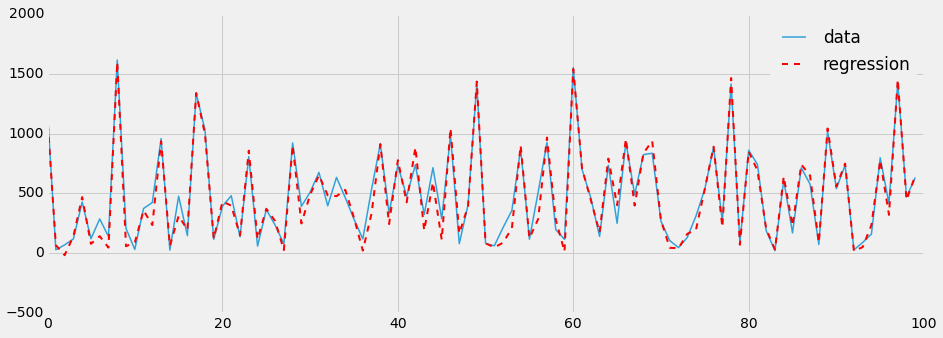

In [11]:
# Try to predict the result "y" from the "X" variables (regression)

regr = MyPredictor(5).fit( X0, y0 )
yp = regr.predict( X0 )

plt.figure(2, (14,5), dpi=200 )
p1 = plt.plot( y0, label="data" )
p2 = plt.plot( yp, c='r', ls='--', lw=2, label="regression")
l = plt.legend()

Now, as usual, we assess the fit by splitting into training/test subsets, and validating on the test set

In [12]:
# Split into train & test
from sklearn.cross_validation import train_test_split

rs = check_random_state( 1349 ) # 1349, 1350
Xr, Xt, yr, yt = train_test_split( X0, y0, test_size=0.30, random_state=rs )

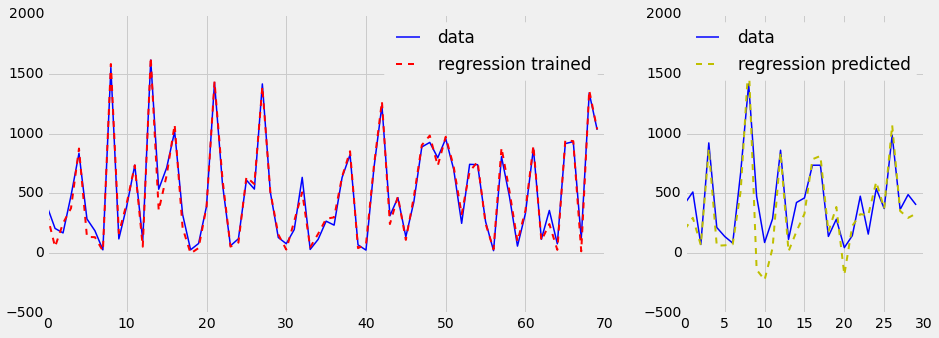

In [13]:
from matplotlib import gridspec

kr = MyPredictor(5).fit( Xr, yr )

ypr = kr.predict( Xr )
ypt = kr.predict( Xt )

plt.figure(2, (14,5), dpi=200 )
gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 0.3]) 

plt.subplot(gs[0])
p1 = plt.plot( yr, c="b", lw=1.5, label="data" )
p2 = plt.plot( ypr, c='r', ls='--', lw=2, label="regression trained")
l = plt.legend()

plt.subplot(gs[1])
p3 = plt.plot( yt, c="b", lw=1.5, label="data" )
p4 = plt.plot( ypt, c='y', ls='--', lw=2, label="regression predicted")
l = plt.legend()

In [14]:
# Measure the error (as RMSE)
from sklearn.metrics import mean_squared_error
err_train = mean_squared_error( ypr, yr )
err_test  = mean_squared_error( ypt, yt )
print "Training error =", err_train, "\nTest error =    ", err_test

Training error = 3438.55575159 
Test error =     32910.9871719


## Effect of model complexity

In [15]:
# Try out different polynomial degrees
# Repeat the procedure a few times, to extract mean behaviour

# Obtain a bigger dataset
X, y = myDataset(1000)

max_deg = 6
num_itr = 20
err_train = np.zeros( (max_deg,num_itr) )
err_test  = np.zeros( (max_deg,num_itr) )

for itr in range(num_itr):
    print "\niteration {:2} :".format(itr+1),
    # Take a sample of the data
    rsample = np.random.choice( X.shape[0], 100, replace=False )
    # Separate that sample into train/test
    subXr, subXt, subyr, subyt = train_test_split( X[rsample,], y[rsample,], test_size=0.30, random_state=rs )
    # Train predictors with that sample, for all intended model complexities
    for degree in range(max_deg):
        print degree+1,
        regr = MyPredictor(degree+1).fit( subXr, subyr )
        ypr = regr.predict( subXr )
        ypt = regr.predict( subXt )
        # Compute the train & test errors
        err_train[degree,itr] = mean_squared_error( subyr, ypr )
        err_test[degree,itr]  = mean_squared_error( subyt, ypt )



iteration  1 : 1 2 3 4 5 6 
iteration  2 : 1 2 3 4 5 6 
iteration  3 : 1 2 3 4 5 6 
iteration  4 : 1 2 3 4 5 6 
iteration  5 : 1 2 3 4 5 6 
iteration  6 : 1 2 3 4 5 6 
iteration  7 : 1 2 3 4 5 6 
iteration  8 : 1 2 3 4 5 6 
iteration  9 : 1 2 3 4 5 6 
iteration 10 : 1 2 3 4 5 6 
iteration 11 : 1 2 3 4 5 6 
iteration 12 : 1 2 3 4 5 6 
iteration 13 : 1 2 3 4 5 6 
iteration 14 : 1 2 3 4 5 6 
iteration 15 : 1 2 3 4 5 6 
iteration 16 : 1 2 3 4 5 6 
iteration 17 : 1 2 3 4 5 6 
iteration 18 : 1 2 3 4 5 6 
iteration 19 : 1 2 3 4 5 6 
iteration 20 : 1 2 3 4 5 6


Now we have all the train & test errors, let's represent them as a function of model complexity. First we'll define a helper class to plot a magnitude with its interval around the mean

In [16]:
class PlotWithIntervals( object ):
    """
    Helper class to plot lines of mean values with intervals around them
    """

    def __init__( self, xaxis=None ):
        self.ylim = np.array( (np.inf,-np.inf) )
        self.xaxis = xaxis
        
    def add( self, values, **kwargs ):
        """Add a result to the graph"""
        if self.xaxis is None:
            self.xaxis = range(values.shape[0])
        value_mean = np.mean( values, axis=1 )
        value_std = np.std( values, axis=1 )
        plt.plot( self.xaxis, value_mean, **kwargs )
        color = { 'color' : kwargs['color'] } if 'color' in kwargs else {}
        plt.fill_between( self.xaxis, value_mean-value_std, value_mean+value_std, alpha=0.15, **color )
        self.ylim[0] = min( self.ylim[0], np.amin(value_mean-value_std) ) 
        self.ylim[1] = max( self.ylim[1], np.amax(value_mean+value_std) ) 
                                
    def xlimits( self, margin=0.05 ):
        """Return the limits for the X axis, leaving a 5% room at each side"""
        xlimits = np.array( (self.xaxis[0], self.xaxis[-1]) )
        return xlimits*(1+margin) - xlimits[::-1]*margin

    def ylimits( self, margin=0.05 ):
        """Return the limits for the Y axis, leaving a 5% room at each side"""
        return self.ylim*(1+margin) - self.ylim[::-1]*margin

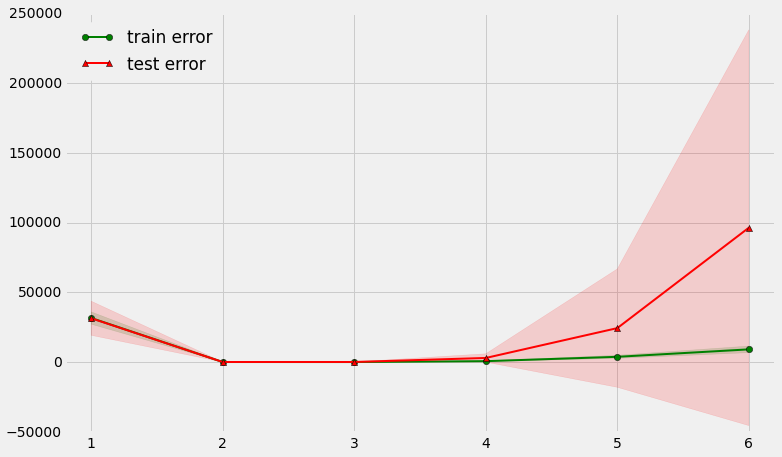

In [17]:
# Now we plot
plt.figure(3, (7*1.62,7), dpi=200 )
xaxis=np.arange(max_deg)+1
plotter = PlotWithIntervals( xaxis=xaxis )
plotter.add( err_train, marker="o", lw=2, color='g', label="train error")
plotter.add( err_test , marker="^", lw=2, color='r', label="test error")
plt.legend( loc=2 )
plt.xlim(0.8,max_deg+0.2)
#plt.ylim(0,50)
xt = plt.xticks( xaxis )

# <a name="curves"></a>Learning & validation curves

Now let's do a similar analysis, but making use of two facilities provided by scikit-learn: the [learning and validation curves](http://scikit-learn.org/stable/modules/learning_curve.html).

## Learning curves
We start with the learning curve: plotting the training & test error as a function of training size. Intuitively, the larger the training set is, the better the estimator will be.

Note that the default scoring parameter of regressions is the [$R^2$ coefficient](http://en.wikipedia.org/wiki/Coefficient_of_determination) (which roughly corresponds to the fraction of explained variance), so this is what we will get as figure of merit.

In [18]:
from sklearn.learning_curve import learning_curve

# Compute the learning curves across a range of train sizes. Do several runs (7)
l_train_sizes, l_train_scores, l_test_scores = learning_curve( MyPredictor(4), X, y, train_sizes=range(40,210,10), cv=7 )

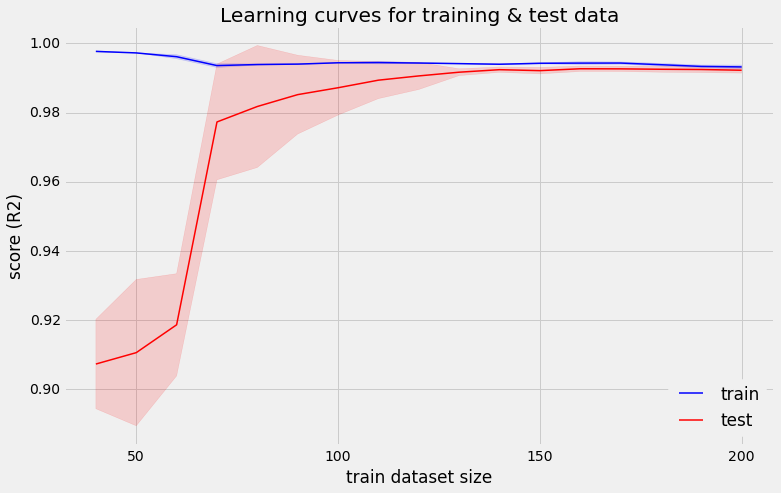

In [19]:
# Plot results
plt.figure( 4, (7*1.62,7))
plotter = PlotWithIntervals( xaxis=l_train_sizes )    
plotter.add( l_train_scores, color="b", label="train" )
plotter.add( l_test_scores, color="r", label="test" )
plt.ylim( plotter.ylimits() )
plt.xlim( plotter.xlimits() )
plt.xlabel( "train dataset size")
plt.ylabel( "score (R2)")
plt.legend( loc=4 );
plt.title( "Learning curves for training & test data" );


## Validation curves
Now the validation curve: we train different models, modifying the moel complexity, and plot the results

In [392]:
from sklearn.learning_curve import validation_curve

# The complexity levels we'll evaluate: polynomial degrees from 1 to 6
degrees = range(1,7)

# This is going to take a while
v_train_scores, v_test_scores = validation_curve(
    MyPredictor(1), X, y, param_name="degree", param_range=degrees,
    cv=8, scoring="r2", n_jobs=3)

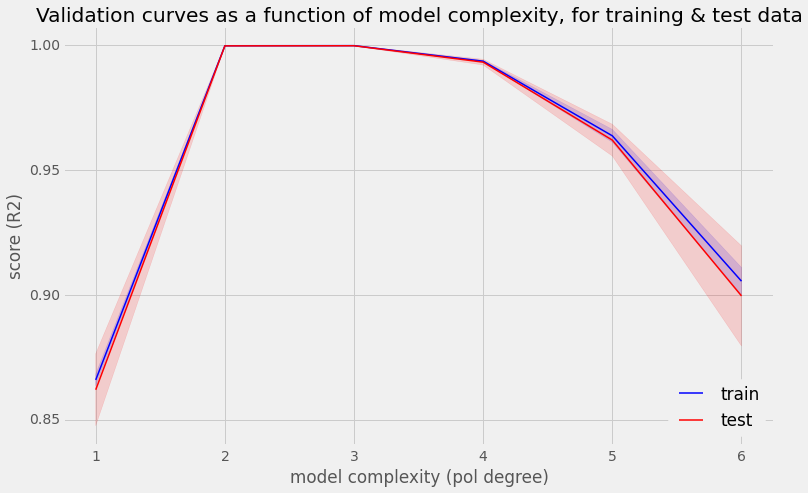

In [427]:
# Plot the results
plt.figure( 4, (7*1.62,7))
plotter = PlotWithIntervals( xaxis=degrees )    
plotter.add( v_train_scores, color="b", label="train" )
plotter.add( v_test_scores, color="r", label="test" )
plt.ylim( plotter.ylimits() )
plt.xlim( plotter.xlimits() )
plt.xlabel( "model complexity (pol degree)")
plt.ylabel( "score (R2)")
plt.legend( loc=4 );
plt.title( "Validation curves as a function of model complexity, for training & test data" );

-----------------------
* Author: _Paulo Villegas, Telefónica I+D_
* Date: _May 2015_